# Eartrainer C++ Core — Notebook Smoke Test
This notebook sets up import paths, imports the package, and runs a small end-to-end session.

In [1]:
# Path setup so Python can find the compiled _earcore module and the Python package
import sys, os
from pathlib import Path

def add_paths():
    cwd = Path.cwd()
    # Walk up to locate eartrainer/eartrainer_Cpp/{build,python}
    for base in [cwd, *cwd.parents]:
        build = base / 'eartrainer' / 'eartrainer_Cpp' / 'build'
        py = base / 'eartrainer' / 'eartrainer_Cpp' / 'python'
        added = False
        if build.exists():
            sys.path.insert(0, str(build))
            added = True
        if py.exists():
            sys.path.insert(0, str(py))
            added = True
        if added:
            return build, py
    return None, None

build_path, py_path = add_paths()
print('Using build path:', build_path)
print('Using python path:', py_path)


Using build path: /Users/itamarshamir/Projects/ear_trainer/eartrainer/eartrainer_Cpp/build
Using python path: /Users/itamarshamir/Projects/ear_trainer/eartrainer/eartrainer_Cpp/python


In [2]:
# Imports
from eartrainer.session_engine import SessionEngine
from eartrainer.models import SessionSpec, ResultMetrics, ResultReport, SessionSummary, TypedPayload

engine = SessionEngine()
print('Capabilities:', engine.capabilities())


Capabilities: {'assists': ['Replay', 'GuideTone', 'TempoDown', 'PathwayHint'], 'drills': ['note', 'interval', 'melody', 'chord'], 'version': 'v1'}


In [3]:
import ctypes, fluidsynth; print('pyfluidsynth OK')

pyfluidsynth OK


In [4]:
# MIDI playback helper
if 'midi_player' in globals():
    try:
        midi_player.close()
    except Exception:
        pass

from eartrainer import SimpleMidiPlayer

midi_player = SimpleMidiPlayer()

def play_prompt(bundle):
    """Play the prompt for a QuestionBundle or AssistBundle."""
    prompt = getattr(bundle, 'prompt', None)
    if prompt is None:
        print('No prompt available for playback.')
        return
    midi_player.play_prompt(prompt)

def stop_audio():
    """Stop any sustained notes without tearing down the synth."""
    midi_player.stop_all()


fluidsynth: warning: SDL3 not initialized, SDL3 audio driver won't be usable. Have you called SDL_Init(SDL_INIT_AUDIO) ?


In [5]:
# Run a tiny note session end-to-end
spec = SessionSpec(
    version='v1',
    drill_kind='note',
    key='C major',
    range=[48, 72],
    tempo_bpm=90,
    n_questions=3,
    generation='adaptive',
    assistance_policy={'GuideTone': 1, 'Replay': 2},
    sampler_params={},
    seed=123,
)

session_id = engine.create_session(spec)
print('Session ID:', session_id)

results = []
while True:
    nxt = engine.next_question(session_id)
    # SessionSummary has attribute 'results'; QuestionBundle has 'question_id'
    if hasattr(nxt, 'results'):
        print('Session complete. Totals:', nxt.totals)
        break

    print('Q:', nxt.question_id, 'type:', nxt.question.type, 'payload:', nxt.question.payload)
    # Pull a guide tone assist if available
    try:
        assist = engine.assist(session_id, nxt.question_id, 'GuideTone')
        print('Assist:', assist.kind, assist.ui_delta)
    except Exception as e:
        print('Assist error:', e)

    # UI owns correctness; here we submit the provided correct answer
    metrics = ResultMetrics(rt_ms=900, attempts=1, assists_used={})
    report = ResultReport(
        question_id=nxt.question_id,
        final_answer=TypedPayload(type=nxt.correct_answer.type, payload=dict(nxt.correct_answer.payload)),
        correct=True,
        metrics=metrics,
        client_info={'source': 'notebook'},
    )
    engine.submit_result(session_id, report)


Session ID: sess-1
Q: q-001 type: note payload: {'degree': 4, 'midi': 55, 'tonic_midi': 60}
Assist: GuideTone {'message': 'Guide tone provided'}
Q: q-002 type: note payload: {'degree': 6, 'midi': 59, 'tonic_midi': 60}
Assist: GuideTone {'message': 'Guide tone provided'}
Q: q-003 type: note payload: {'degree': 2, 'midi': 64, 'tonic_midi': 60}
Assist: GuideTone {'message': 'Guide tone provided'}
Session complete. Totals: {'avg_rt_ms': 900, 'correct': 3, 'incorrect': 0}


In [6]:
# Try a chord question (single step)
spec_chord = SessionSpec(
    drill_kind='chord', n_questions=1, generation='eager', seed=42, assistance_policy={'Replay': 1}
)
sid = engine.create_session(spec_chord)
q = engine.next_question(sid)
print('Chord Q:', q.question_id, q.question.type, q.prompt.modality if q.prompt else None)
metrics = ResultMetrics(rt_ms=700, attempts=1, assists_used={})
engine.submit_result(sid, ResultReport(
    question_id=q.question_id,
    final_answer=TypedPayload(type=q.correct_answer.type, payload=dict(q.correct_answer.payload)),
    correct=True, metrics=metrics, client_info={}))
print('Chord summary:', engine.next_question(sid).totals)


Chord Q: q-001 chord midi-clip
Chord summary: {'avg_rt_ms': 700, 'correct': 1, 'incorrect': 0}


In [7]:
# Helpers and note sampling utilities
NOTE_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

def midi_to_name(midi: int) -> str:
    note = NOTE_NAMES[midi % 12]
    octave = midi // 12 - 1
    return f"{note}{octave}"

def wrap_scale_degree(degree: int) -> int:
    idx = degree % 7
    if idx < 0:
        idx += 7
    return idx + 1

def sample_note_questions(key: str = 'C major', n: int = 20, seed: int = 101):
    spec = SessionSpec(
        drill_kind='note',
        key=key,
        n_questions=n,
        generation='eager',
        assistance_policy={},
        seed=seed,
    )
    session_id = engine.create_session(spec)
    rows = []
    for _ in range(n):
        bundle = engine.next_question(session_id)
        if isinstance(bundle, SessionSummary):
            break
        raw = bundle.question.payload
        rows.append({
            'question_id': bundle.question_id,
            'raw': raw,
            'degree_raw': raw['degree'],
            'note_name': midi_to_name(raw['midi']),
        })
        metrics = ResultMetrics(rt_ms=600, attempts=1, assists_used={})
        report = ResultReport(
            question_id=bundle.question_id,
            final_answer=bundle.correct_answer,
            correct=True,
            metrics=metrics,
            client_info={'source': 'notebook-note-sample'},
        )
        engine.submit_result(session_id, report)
    return rows

note_key = 'B major'
note_seed = 101
note_samples = sample_note_questions(key=note_key, n=20, seed=note_seed)
print(f'Key: {note_key} (seed={note_seed})')
for item in note_samples:
    print(f"{item['question_id']}: degree {item['degree_raw']} (raw={item['degree_raw']}) -> {item['note_name']} | payload={item['raw']}")



Key: B major (seed=101)
q-001: degree 4 (raw=4) -> F#4 | payload={'degree': 4, 'midi': 66, 'tonic_midi': 59}
q-002: degree 1 (raw=1) -> C#4 | payload={'degree': 1, 'midi': 61, 'tonic_midi': 59}
q-003: degree 0 (raw=0) -> B4 | payload={'degree': 0, 'midi': 71, 'tonic_midi': 59}
q-004: degree 3 (raw=3) -> E3 | payload={'degree': 3, 'midi': 52, 'tonic_midi': 59}
q-005: degree 4 (raw=4) -> F#3 | payload={'degree': 4, 'midi': 54, 'tonic_midi': 59}
q-006: degree 3 (raw=3) -> E4 | payload={'degree': 3, 'midi': 64, 'tonic_midi': 59}
q-007: degree 5 (raw=5) -> G#4 | payload={'degree': 5, 'midi': 68, 'tonic_midi': 59}
q-008: degree 6 (raw=6) -> A#3 | payload={'degree': 6, 'midi': 58, 'tonic_midi': 59}
q-009: degree 1 (raw=1) -> C#3 | payload={'degree': 1, 'midi': 49, 'tonic_midi': 59}
q-010: degree 0 (raw=0) -> B3 | payload={'degree': 0, 'midi': 59, 'tonic_midi': 59}
q-011: degree 2 (raw=2) -> D#4 | payload={'degree': 2, 'midi': 63, 'tonic_midi': 59}
q-012: degree 6 (raw=6) -> A#3 | payload={'de

In [13]:
# Chord sampling preview
def sample_chord_questions(key: str = 'C major', n: int = 60, seed: int = 202):
    spec = SessionSpec(
        drill_kind='chord',
        key=key,
        n_questions=n,
        generation='eager',
        assistance_policy={},
        seed=seed,
    )
    session_id = engine.create_session(spec)
    rows = []
    prompts = []
    for _ in range(n):
        bundle = engine.next_question(session_id)
        prompts.append(bundle)
        if isinstance(bundle, SessionSummary):
            break
        raw = bundle.question.payload
        voicing_names = [midi_to_name(m) for m in raw['voicing_midi']]
        rows.append({
            'question_id': bundle.question_id,
            'degree': wrap_scale_degree(raw['root_degree']),
            'quality': raw.get('quality'),
            'voicing': voicing_names,
            'raw': raw,
        })
        metrics = ResultMetrics(rt_ms=600, attempts=1, assists_used={})
        report = ResultReport(
            question_id=bundle.question_id,
            final_answer=bundle.correct_answer,
            correct=True,
            metrics=metrics,
            client_info={'source': 'notebook-chord-sample'},
        )
        engine.submit_result(session_id, report)
    return rows, prompts

chord_key = 'C major'
chord_seed = 202
chord_samples, prompts = sample_chord_questions(key=chord_key, n=60, seed=chord_seed)
print(f'Key: {chord_key} (seed={chord_seed})')
for item in chord_samples:
    voicing_str = ', '.join(item['voicing'])
    if item['degree'] == 7:
        print(f"{item['question_id']}: degree {item['degree']} ({item['quality']}) -> {voicing_str}")
    #print(f"    raw={item['raw']}")

for p in prompts[1:4]:
    play_prompt(p)
    time.sleep(0.5)



Key: C major (seed=202)
q-001: degree 7 (diminished) -> B1, F3, B3, D4
q-008: degree 7 (diminished) -> B1, B3, D4, F4
q-014: degree 7 (diminished) -> B1, B3, D4, F4, B4
q-016: degree 7 (diminished) -> B1, B3, D4, F4, B4
q-021: degree 7 (diminished) -> B1, B3, D4, F4
q-025: degree 7 (diminished) -> B1, F3, B3, D4
q-039: degree 7 (diminished) -> B1, B3, D4, F4
q-041: degree 7 (diminished) -> B1, F3, B3, D4
q-049: degree 7 (diminished) -> B1, B3, D4, F4


In [9]:
import time
# Interval sampling preview
def sample_interval_questions(key: str = 'C major', n: int = 20, seed: int = 303):
    spec = SessionSpec(
        drill_kind='interval',
        key=key,
        n_questions=n,
        generation='eager',
        assistance_policy={},
        seed=seed,
    )
    session_id = engine.create_session(spec)
    rows = []
    prompts = []
    for _ in range(n):
        bundle = engine.next_question(session_id)
        prompts.append(bundle)
        if isinstance(bundle, SessionSummary):
            break
        payload = bundle.question.payload
        bottom_name = midi_to_name(payload['bottom_midi'])
        top_name = midi_to_name(payload['top_midi'])
        rows.append({
            'question_id': bundle.question_id,
            'bottom_deg': payload['bottom_degree'],
            'top_deg': payload['top_degree'],
            'bottom_midi': bottom_name,
            'top_midi': top_name,
            'raw': payload,
            'answer': bundle.correct_answer.payload,
        })
        metrics = ResultMetrics(rt_ms=650, attempts=1, assists_used={})
        report = ResultReport(
            question_id=bundle.question_id,
            final_answer=bundle.correct_answer,
            correct=True,
            metrics=metrics,
            client_info={'source': 'notebook-interval-sample'},
        )
        engine.submit_result(session_id, report)
    return rows, prompts

interval_key = 'C major'
interval_seed = 303
interval_samples, prompts = sample_interval_questions(key=interval_key, n=20, seed=interval_seed)
print(f'Key: {interval_key} (seed={interval_seed})')
for item in interval_samples:
    bottom = item['bottom_midi']
    top = item['top_midi']
    answer = item['answer']
    answer_name = answer.get('name') if isinstance(answer, dict) else answer
    print(f"{item['question_id']}: bottom deg {item['bottom_deg']} -> {bottom}, top deg {item['top_deg']} -> {top} | interval {answer_name} | raw={item['raw']}")

for p in prompts[:3]:
    play_prompt(p)
    time.sleep(1)

stop_audio()


Key: C major (seed=303)
q-001: bottom deg 6 -> B4, top deg 12 -> A5 | interval m7 | raw={'bottom_degree': 6, 'bottom_midi': 71, 'orientation': 'ascending', 'top_degree': 12, 'top_midi': 81}
q-002: bottom deg 0 -> C4, top deg 4 -> G4 | interval P5 | raw={'bottom_degree': 0, 'bottom_midi': 60, 'orientation': 'ascending', 'top_degree': 4, 'top_midi': 67}
q-003: bottom deg 3 -> F3, top deg 4 -> G3 | interval M2 | raw={'bottom_degree': 3, 'bottom_midi': 53, 'orientation': 'descending', 'top_degree': 4, 'top_midi': 55}
q-004: bottom deg 2 -> E3, top deg 3 -> F3 | interval m2 | raw={'bottom_degree': 2, 'bottom_midi': 52, 'orientation': 'descending', 'top_degree': 3, 'top_midi': 53}
q-005: bottom deg 5 -> A4, top deg 12 -> A5 | interval P1 | raw={'bottom_degree': 5, 'bottom_midi': 69, 'orientation': 'descending', 'top_degree': 12, 'top_midi': 81}
q-006: bottom deg 3 -> F4, top deg 9 -> E5 | interval M7 | raw={'bottom_degree': 3, 'bottom_midi': 65, 'orientation': 'ascending', 'top_degree': 9, '

In [10]:
# Generate 20 note questions with pathways enabled and print prompt notes
from eartrainer.session_engine import SessionEngine
from eartrainer.models import SessionSpec

engine = SessionEngine()
spec = SessionSpec(
    drill_kind='note',
    key='C major',
    tempo_bpm=110,
    n_questions=20,
    generation='eager',
    assistance_policy={'Replay': 1},
    sampler_params={
        'use_pathway': True,
        'pathway_tempo_bpm': 90,    # pathway tempo; falls back to tempo_bpm if omitted
        'pathway_step_beats': 1.0,  # quarter notes
        'pathway_rest_beats': 1.5,  # eighth-note rest before resolution
        'pathway_repeat_lead': True,
    },
    seed=2025,
)

sid = engine.create_session(spec)
prompts = []
rows = []
for _ in range(spec.n_questions):
    q = engine.next_question(sid)
    prompts.append(q)
    if q.prompt is None:
        continue
    clip = q.prompt.midi_clip if q.prompt else None
    # Summarize first track events as (t, type, note)
    if clip and clip.tracks:
        evs = [(ev.t, ev.type, ev.note) for ev in clip.tracks[0].events[:8]]
    else:
        evs = []
    rows.append((q.question_id, q.question.payload, evs))
    fake = ResultReport(
        question_id=q.question_id,
        final_answer=TypedPayload(type=q.correct_answer.type, payload={'degree': q.correct_answer.payload['degree']}),
        correct=True,
        metrics=ResultMetrics(rt_ms=0, attempts=1)
    )
    engine.submit_result(sid, fake)

# Pretty print first few prompts; full data is in 'rows'
for row in rows:
    print(row[0], 'payload=', row[1], 'notes=', row[2])

for p in prompts[:2]:
    play_prompt(p)
    print(p.prompt.midi_clip)
    time.sleep(1)

stop_audio()

len(rows)


q-001 payload= {'degree': 4, 'midi': 67, 'tonic_midi': 60} notes= [(0, 'note_on', 67), (480, 'note_off', 67), (1200, 'note_on', 67), (1680, 'note_off', 67), (1680, 'note_on', 69), (2160, 'note_off', 69), (2160, 'note_on', 71), (2640, 'note_off', 71)]
q-002 payload= {'degree': 5, 'midi': 69, 'tonic_midi': 60} notes= [(0, 'note_on', 69), (480, 'note_off', 69), (1200, 'note_on', 69), (1680, 'note_off', 69), (1680, 'note_on', 71), (2160, 'note_off', 71), (2160, 'note_on', 72), (2640, 'note_off', 72)]
q-003 payload= {'degree': 6, 'midi': 71, 'tonic_midi': 60} notes= [(0, 'note_on', 71), (480, 'note_off', 71), (1200, 'note_on', 71), (1680, 'note_off', 71), (1680, 'note_on', 72), (2160, 'note_off', 72)]
q-004 payload= {'degree': 0, 'midi': 60, 'tonic_midi': 60} notes= [(0, 'note_on', 60), (480, 'note_off', 60), (1200, 'note_on', 60), (1680, 'note_off', 60)]
q-005 payload= {'degree': 5, 'midi': 69, 'tonic_midi': 60} notes= [(0, 'note_on', 69), (480, 'note_off', 69), (1200, 'note_on', 69), (168

20

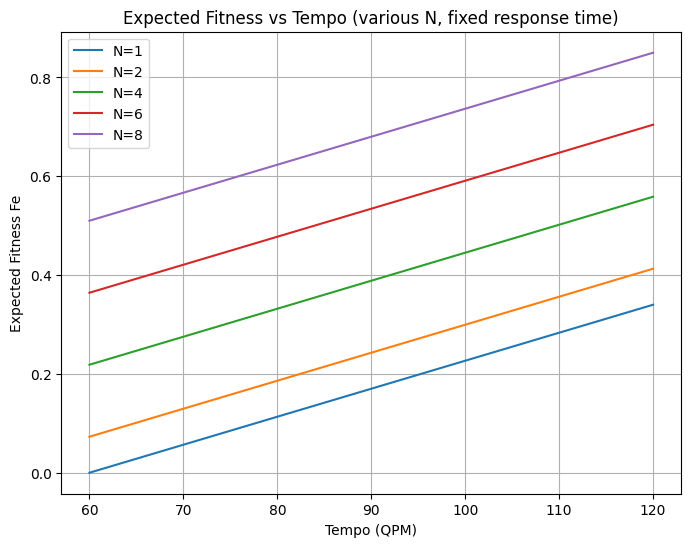

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (from the simplified model)
N_max = 8
t_min, t_max = 60, 120   # tempo range (quarter notes per minute)
wN = 0.6
p_star = 0.85

def q_difficulty(N, N_max, tempo, t_min, t_max, wN):
    n = (N - 1) / (N_max - 1)
    t = (tempo - t_min) / (t_max - t_min)
    return np.clip(wN * n + (1.0 - wN) * t, 0.0, 1.0)

def expected_item(N, tempo, N_max, t_min, t_max, wN, p_star):
    q = q_difficulty(N, N_max, tempo, t_min, t_max, wN)
    return p_star * q

# Plot expected fitness vs tempo for various N
tempos = np.linspace(t_min, t_max, 200)
plt.figure(figsize=(8,6))

for N in [1, 2, 4, 6, 8]:
    Fe_values = [expected_item(N, tempo, N_max, t_min, t_max, wN, p_star) for tempo in tempos]
    plt.plot(tempos, Fe_values, label=f"N={N}")

plt.title("Expected Fitness vs Tempo (various N, fixed response time)")
plt.xlabel("Tempo (QPM)")
plt.ylabel("Expected Fitness Fe")
plt.legend()
plt.grid(True)
plt.show()

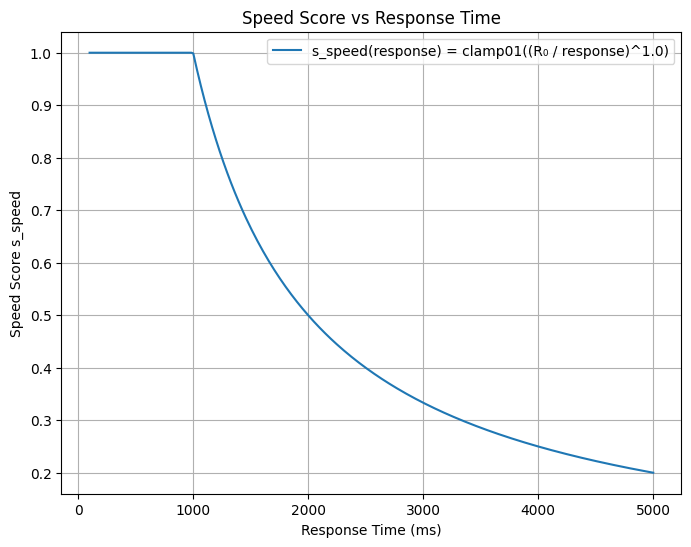

In [18]:
# plot s_speed(response) = clamp01( (R₀ / response)^β ) as function of response time
R0 = 1000  # reference response time in ms
beta = 1.0  # speed exponent
responses = np.linspace(100, 5000, 300)
s_speed_values = np.clip((R0 / responses) ** beta, 0.0, 1.0)
plt.figure(figsize=(8,6))
plt.plot(responses, s_speed_values, label=f"s_speed(response) = clamp01((R₀ / response)^{beta})")
plt.title("Speed Score vs Response Time")
plt.xlabel("Response Time (ms)")
plt.ylabel("Speed Score s_speed")
plt.legend()
plt.grid(True)
plt.show()

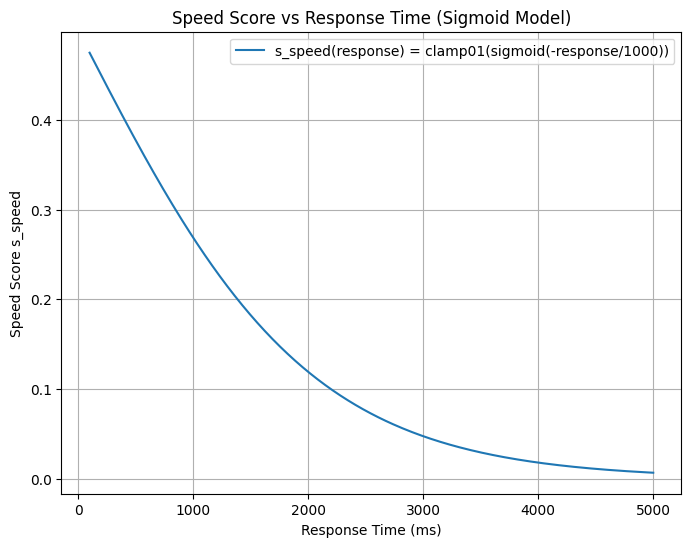

In [19]:
# plot s_speed(response) = clamp01(sigmoid( - response/T0 )) as function of response time
T0 = 1000  # time constant in ms
s_speed_sigmoid = np.clip(1 / (1 + np.exp(responses / T0)), 0.0, 1.0)
plt.figure(figsize=(8,6))
plt.plot(responses, s_speed_sigmoid, label=f"s_speed(response) = clamp01(sigmoid(-response/{T0}))")
plt.title("Speed Score vs Response Time (Sigmoid Model)")
plt.xlabel("Response Time (ms)")
plt.ylabel("Speed Score s_speed")
plt.legend()
plt.grid(True)
plt.show()

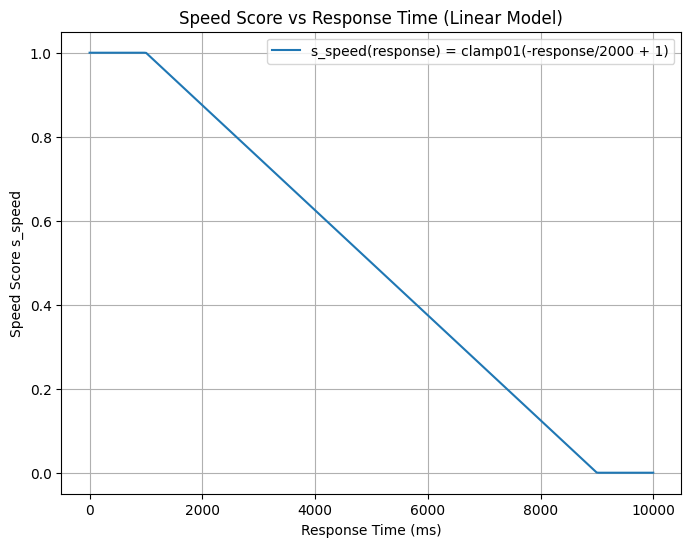

In [31]:
# plot s_speed(response) = clamp01( - response/T0 + beta) as function of response time
Tmax = 5000  # time constant in ms
Tmin = 1000
beta = 1  # offset
responses = np.linspace(0, 10000, 300)
s_speed_linear = np.clip(- 0.5 * (responses - Tmin) / (Tmax - Tmin) + 1, 0, 1.0)
plt.figure(figsize=(8,6))
plt.plot(responses, s_speed_linear, label=f"s_speed(response) = clamp01(-response/{T0} + {beta})")
plt.title("Speed Score vs Response Time (Linear Model)")
plt.xlabel("Response Time (ms)")
plt.ylabel("Speed Score s_speed")
plt.legend()
plt.grid(True)
plt.show()